# Mapping and classifying cells using Human Lung Cell Atlas

## Environment Setup

In [1]:
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [57]:
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import gdown
import gzip
import shutil

In [3]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.3.0
absl                        NA
asttokens                   NA
attr                        22.1.0
backcall                    0.2.0
brotli                      NA
bs4                         4.11.1
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          2.0.4
chex                        0.1.5
contextlib2                 NA
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
deprecate                   0.3.2
docrep                      0.3.2
entrypoints                 0.4
executing                   0.8.3
filelock                    3.8.0
flax                        0.6.1
fsspec                      2022.11.0
gdown                       4.5.3
google                      NA
h5py                        3.7.0
idna   

## Download Files - Reference model, Embeddings etc.

In [4]:
if not os.path.isdir("../data"):
    os.mkdir("../data")    

In [5]:
os.chdir('../data')

In [6]:
url = 'https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad'
output = 'HLCA_emb_and_metadata.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_emb_and_metadata.h5ad
100%|██████████| 218M/218M [00:53<00:00, 4.10MB/s] 


'HLCA_emb_and_metadata.h5ad'

In [7]:
url = 'https://zenodo.org/record/6337966/files/HLCA_reference_model.zip'
output = 'HLCA_reference_model.zip'
gdown.download(url, output, quiet=False)
shutil.unpack_archive('HLCA_reference_model.zip')
os.remove(output)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_reference_model.zip
100%|██████████| 5.32M/5.32M [00:01<00:00, 4.23MB/s]


## Download query data

In [8]:
query_data_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5230027&format=file&file=GSM5230027%5F04%2DP103142%2DS149%2DR01%5Fraw%5Ffeature%5Fbc%5Fmatrix%2Eh5%2Egz"
query_metadata_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE171668&format=file&file=GSE171668%5Flung%5Fmetadata%2Ecsv%2Egz"

In [9]:
output = 'query.h5.gz'
gdown.download(query_data_url, output, quiet=False)
with gzip.open('query.h5.gz', 'rb') as f_in:
    with open('query.h5', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
os.remove("query.h5.gz")

Downloading...
From: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5230027&format=file&file=GSM5230027%5F04%2DP103142%2DS149%2DR01%5Fraw%5Ffeature%5Fbc%5Fmatrix%2Eh5%2Egz
To: /home/icb/aleksandra.topalova/scarches/data/query.h5.gz
100%|██████████| 27.4M/27.4M [00:01<00:00, 16.0MB/s]


In [10]:
output = 'query_obs.csv.gz'
gdown.download(query_metadata_url, output, quiet=False)

Downloading...
From: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE171668&format=file&file=GSE171668%5Flung%5Fmetadata%2Ecsv%2Egz
To: /home/icb/aleksandra.topalova/scarches/data/query_obs.csv.gz
100%|██████████| 1.95M/1.95M [00:00<00:00, 2.71MB/s]


'query_obs.csv.gz'

## Preprocessing

In [11]:
query_data_full = sc.read_10x_h5("query.h5")
    # clean up .var.index (gene names)
query_data_full.var['gene_names'] = query_data_full.var.index
query_data_full.var.index = [idx.split("___")[-1] for idx in query_data_full.var.gene_ids]
    # clean up cell barcodes:
query_data_full.obs.index = query_data_full.obs.index.str.rstrip("-1")
    # read in metadata (to select only cells of interest and remove empty drops)
query_data_meta = pd.read_csv("query_obs.csv.gz",index_col=0)
    # subset to cells from our sample
query_data_meta = query_data_meta.loc[query_data_meta.donor == "D12_4",:].copy()
    # clean up barcodes:
query_data_meta.index = [idx.split("-")[-1] for idx in query_data_meta.index]
    # subset adata to cells in metadata:
query_data_full = query_data_full[query_data_meta.index,:].copy()
    # add dataset information:
query_data_full.obs['dataset'] = 'test_dataset_delorey_regev'

In [12]:
# gene order for scArches model
reference_gene_order = pd.read_csv('HLCA_reference_model/var_names.csv')
# reference embedding, including cell/sample/subject metadata:
reference_embedding = sc.read_h5ad('HLCA_emb_and_metadata.h5ad')

In [13]:
sca.models.SCANVI.convert_legacy_save("HLCA_reference_model", "HLCA_reference_model", overwrite=True)

In [14]:
ref_model_path = 'HLCA_reference_model'
query_data = sca.models.SCANVI.prepare_query_anndata(
    adata = query_data_full,
    reference_model = ref_model_path,
    inplace=False)

INFO     File HLCA_reference_model/model.pt already downloaded                                                     
INFO     Found 99.65% reference vars in query data.                                                                


In [15]:
query_data.obs['scanvi_label'] = 'unlabeled'

## Perform surgery

In [16]:
batch_key = 'dataset'
query_batch = ['test_dataset_delorey_regev']

In [17]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

Surgery

In [18]:
surgery_model = sca.models.SCANVI.load_query_data(
        query_data,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File HLCA_reference_model/model.pt already downloaded                                                     


In [19]:
surgery_model._unlabeled_indices = np.arange(query_data.n_obs)
surgery_model._labeled_indices = []

In [20]:
#TODO: Check args
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:Multiprocessing is handled by SLURM.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:pytorch_lightning.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 500/500: 100%|██████████| 500/500 [01:47<00:00,  5.91it/s, loss=510, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:47<00:00,  4.63it/s, loss=510, v_num=1]


In [21]:
surgery_path = 'surgery_model'
surgery_model.save(surgery_path, overwrite=True)

### Get latent representation

In [22]:
query_data_latent = sc.AnnData(surgery_model.get_latent_representation(query_data))
query_data_latent.obs = query_data.obs.loc[query_data.obs.index,:]

# Combine embeddings

In [23]:
query_data_latent.obs['ref_or_query'] = "query"
reference_embedding.obs['ref_or_query'] = "ref"

In [24]:
combined_emb = reference_embedding.concatenate(query_data_latent, index_unique=None)

# UMAP

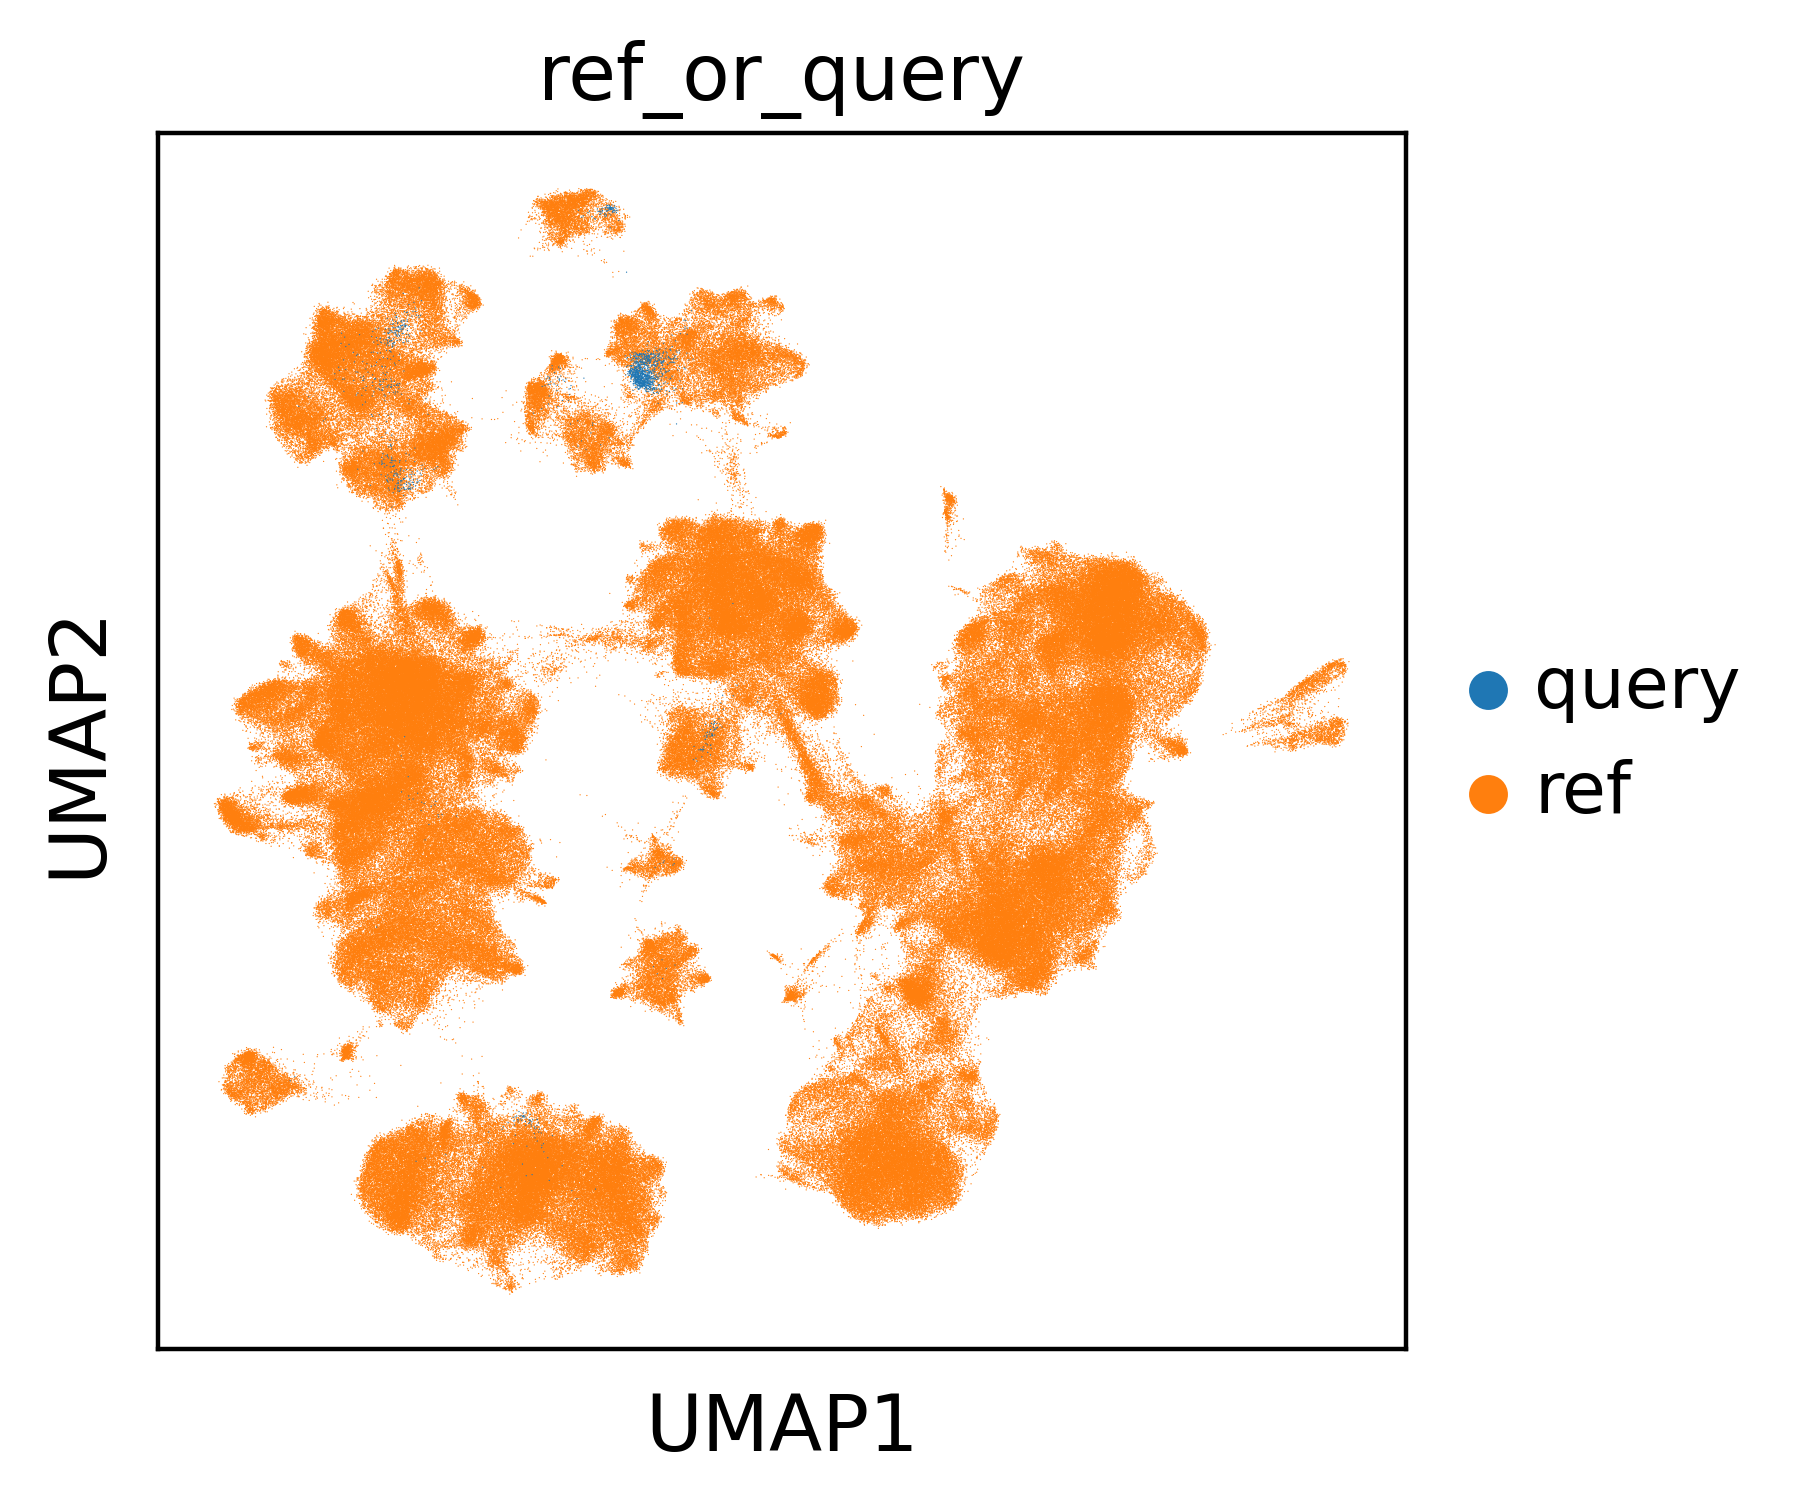

In [25]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)
sc.pl.umap(combined_emb, color="ref_or_query")

Saving combined embeddings (optional)

In [26]:
combined_emb.write_h5ad('../data/combined_embedding.h5ad')

# Label transfer

In [44]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
output_celltypes = '../data/HLCA_celltypes_ordered.csv'
gdown.download(url, output_celltypes, quiet=False)


Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_celltypes_ordered.csv
5.81kB [00:00, 34.4kB/s]                   


'../data/HLCA_celltypes_ordered.csv'

In [45]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_scarches_gene_order.csv'
output_gene_order = '../data/HLCA_scarches_gene_order.csv'
gdown.download(url, output_gene_order, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_scarches_gene_order.csv
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_scarches_gene_order.csv
45.1kB [00:00, 27.7MB/s]                   


'../data/HLCA_scarches_gene_order.csv'

In [46]:
cts_ordered = pd.read_csv(output_celltypes,index_col=0)    

In [53]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=reference_embedding,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [58]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=query_data_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = reference_embedding.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
uncertainty_threshold = 0.2

In [ ]:
labels.rename(columns={f"Level_{lev}":f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)},inplace=True)
uncert.rename(columns={f"Level_{lev}":f"Level_{lev}_transfer_uncert" for lev in range(1,6)},inplace=True)

In [ ]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [ ]:
# convert to arrays instead of categoricals, and set "nan" to NaN 
for col in combined_emb.obs.columns:
    if col.endswith("_transfer_uncert"):
        combined_emb.obs[col] = list(np.array(combined_emb.obs[col]))
    elif col.endswith("_transfered_label_unfiltered"):
        filtered_colname = col.replace("_unfiltered","")
        matching_uncert_col = col.replace("transfered_label_unfiltered","transfer_uncert")
        
        # also create a filtered version, setting cells with too high 
        # uncertainty levels to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace("nan",np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace("nan",np.nan,inplace=True)

In [ ]:
print(f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:")
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/query_data.n_obs*100,2)}%")

In [ ]:
sc.pl.umap(
    combined_emb,
    color=[f"Level_{lev}_transfer_uncert" for lev in range(1,6)],
    ncols=5)

### UMAP Uncertainties 

In [ ]:
sc.pl.umap(combined_emb, color="ann_finest_level")

In [ ]:
combined_emb.write(os.path.join(dir_out,"combined_embedding.h5ad"))